# Bayesian optimization tutorial
## The core idea:
### Let's assume there is a sequence space X (e.g. length N = 5) made up of M discrete values (e.g. M = 4 , A T G C) at index i.
### For each X there is a scalar Y (modelled as the gene expression matrix with interactions and noise)
### Prior Distribution over i is modelled with a random Dirichlet distribution with.
### As an additional constraint the index 3 is fixed to A.
### For the present X to Y is modelled as a GPR.
### The likelihood function as a result is a gaussian: $exp(-0.5 * (Y - f(X))^2)$
### Using this Dirichlet prior and the Gaussian likelihood necessiates using MCMC to sample from the posterior distribution.
### Each iteration will then use used to seed the next prior to find the successive posterior

In [1]:
# imports
# basic stuff
import numpy as np
import matplotlib.pyplot as plt
import itertools
# sklearn imports
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.preprocessing import OneHotEncoder
# pymc3
import pymc3 as pm

/wrk/kaptan/opt/miniconda/envs/bayes/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# functions
# Function to generate Dirichlet distribution at index i
def dirichlet_at_i(i, fixed, alphas=None):
    if alphas is None:
        # If alphas are not provided, select them at random
        alphas = np.random.rand(M)
    if i == fixed[0]:
        alphas = np.full(M, 0.01)  # small positive value for all alphas
        alphas[M_values.index(fixed[1])] = 1
    return np.random.dirichlet(alphas)

# gene expression matrix
def gene_expression(X):
    # Define the PWM (just an example)
    pwm = {'A': [0.1, 0.2, 0.3, 0.4, 0.5],
           'T': [0.2, 0.3, 0.4, 0.5, 0.1],
           'G': [0.3, 0.4, 0.5, 0.1, 0.2],
           'C': [0.4, 0.5, 0.1, 0.2, 0.3]}
    
    # Calculate the PWM score
    pwm_score = sum(pwm[X[i]][i] for i in range(len(X)))
    
    # Define the interactions (just an example)
    interactions = [(0, 1), (2, 3), (3, 4)]
    
    # Calculate the interaction score
    interaction_score = sum((X[i] == X[j]) for i, j in interactions)
    
    # Calculate Y
    Y = pwm_score + interaction_score
    
    # Add some noise
    Y += np.random.normal(0, 0.1)https://forms.gle/dXYYr5FkfoV2jRAa7

# Function to convert a sequence to a number
def sequence_to_number(seq):
    mapping = {'A': 0, 'T': 1, 'G': 2, 'C': 3}
    return sum(mapping[seq[i]] * (4 ** i) for i in range(len(seq)))


# Function to convert a number back to a sequence
def number_to_sequence(num, len_seq = 5):
    mapping = {0: 'A', 1: 'T', 2: 'G', 3: 'C'}
    seq = ''
    for _ in range(len_seq):  # assuming the length of the sequence is 5
        seq += mapping[num % 4]
        num //= 4
    return seq[::-1]  # reverse the sequence

In [3]:
# Set the parameters
N = 5
j = 3
M_values = ['A', 'T', 'G', 'C']
M = len(M_values)

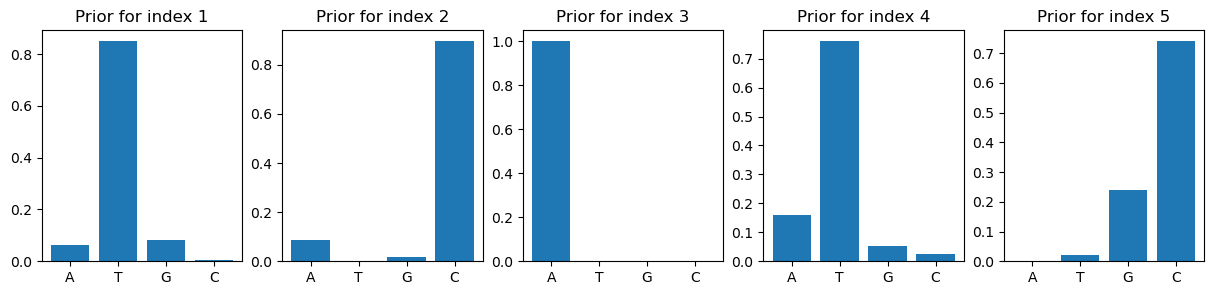

In [4]:
# Set the fixed index and value
fixed = [2, 'A']  # 0-based index

# Initialize the prior with the Dirichlet distribution for each index
prior = np.array([dirichlet_at_i(i, fixed) for i in range(N)])

# Normalize the prior to make sure it's a proper distribution
prior = prior / prior.sum(axis=1, keepdims=True)

# Plot the prior for each index
fig, axs = plt.subplots(1, N, figsize=(15, 3))
for i in range(N):
    axs[i].bar(M_values, prior[i, :])
    axs[i].set_title(f'Prior for index {i+1}')
plt.show()

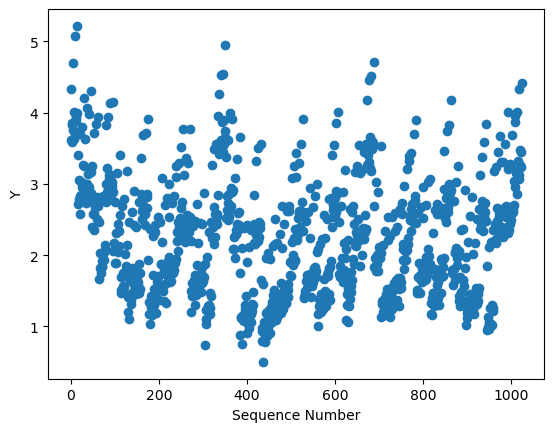

In [5]:
# Generate all possible sequences
sequences = np.array([''.join(seq) for seq in itertools.product(M_values, repeat=N)])

# One-hot encode the sequences
encoder = OneHotEncoder(sparse_output=False)
encoder.fit_transform(np.array([list(seq) for seq in sequences]))

# Calculate X and Y values for the plot
seq1d_values = [sequence_to_number(seq) for seq in sequences]
Y_values = [gene_expression(seq) for seq in sequences]

# Plot X vs Y
plt.scatter(seq1d_values, Y_values)
plt.xlabel('Sequence Number')
plt.ylabel('Y')
plt.show()

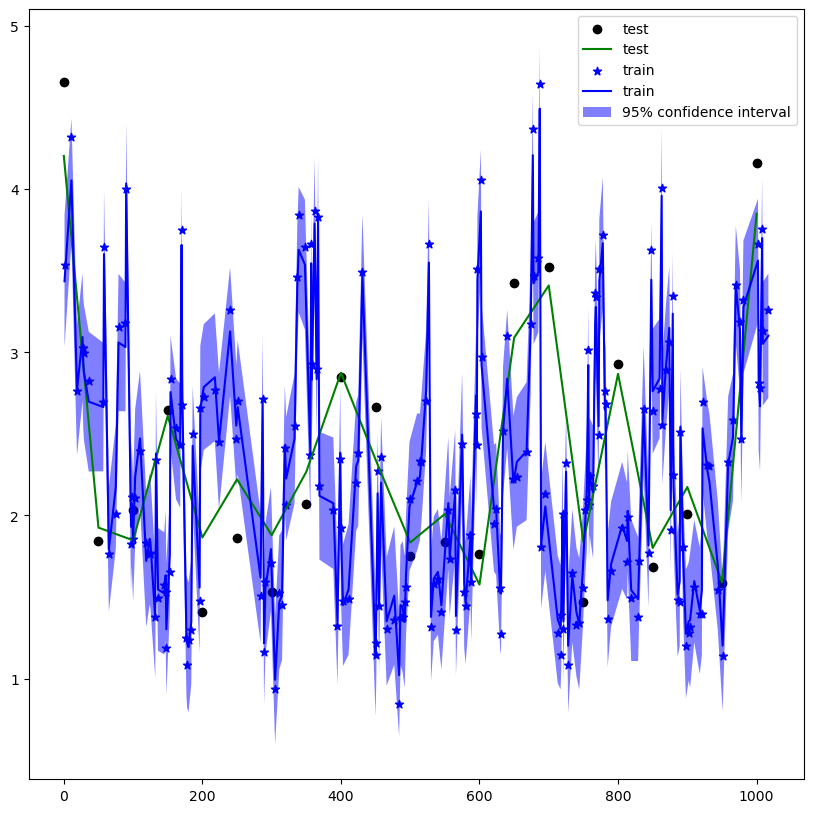

In [18]:
# Randomly select 10 sequences
np.random.seed(42)  # for reproducibility
selected_sequences = np.random.choice(sequences, size=200, replace=False)
#selected_sequences = sequences[::50]
seq1d_selected = [sequence_to_number(seq) for seq in selected_sequences]
# Calculate X and Y values for the selected sequences
X_selected = encoder.transform(np.array([list(seq) for seq in selected_sequences]))
Y_selected = np.array([gene_expression(seq) for seq in selected_sequences])

# Define the kernel function
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))

# Create the Gaussian Process model
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=200, alpha=0.1, normalize_y=True)

# Fit the model to the data
gp.fit(X_selected, Y_selected)
# sort the selected sequnces by 1d index
sort_indices = np.argsort(seq1d_selected)
# Use these indices to sort seq1d_selected, Y_train, and sigma
seq1d_selected_sorted = np.array(seq1d_selected)[sort_indices]
y_selected_sorted = Y_selected[sort_indices]

# Make the prediction on the sorted sequences
Y_train_pred, sigma_train = gp.predict(X_selected[sort_indices], return_std=True)

# Generate test points for prediction
seq1d_test = np.linspace(min(seq1d_values), max(seq1d_values), 1024).reshape(-1,1)[::50]
# Convert seq1d_test numbers back into sequences
seq_test = np.array([number_to_sequence(int(num)) for num in seq1d_test]).reshape(-1, 1)
# Transform the test sequences with the encoder
X_test = encoder.transform(np.array([list(seq[0]) for seq in seq_test]))
Y_test = np.array([gene_expression(seq[0]) for seq in seq_test])

# Make the prediction on the sorted sequences
Y_test_pred, sigma_test = gp.predict(X_test, return_std=True)

# plot
plt.figure(figsize = (10,10))

plt.scatter(seq1d_test, Y_test, c = 'k', label='test')
plt.plot(seq1d_test, Y_test_pred, c = 'g', label='test')


plt.scatter(seq1d_selected_sorted,y_selected_sorted, c = 'b', label = 'train', marker = '*')
plt.plot(seq1d_selected_sorted,Y_train_pred, c = 'b', label = 'train')
plt.fill(np.concatenate([seq1d_selected_sorted, seq1d_selected_sorted[::-1]]),
         np.concatenate([Y_train_pred - 1.9600 * sigma_train,
                        (Y_train_pred + 1.9600 * sigma_train)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.legend()